In [2]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Importamos los datos y comprobamos que estan correctos
aapl_df = pd.read_csv('aapl.csv', sep=';')
aapl_df['fecha'] = pd.to_datetime(aapl_df['fecha'])
aapl_df = aapl_df.set_index('fecha')
aapl_df.head()

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493
1990-03-30,Q2 1990,1346
1990-06-29,Q3 1990,1365
1990-09-28,Q4 1990,1354
1990-12-28,Q1 1991,1676


In [5]:
# Comvertimos los datos en Quartos (trimestres) y los visualizamos
aapl_ts = aapl_df.resample("q").last()
aapl_ts = aapl_ts.drop(columns='Trimeste')
aapl_ts

,Ingresos
fecha,
1989-12-31,1493
1990-03-31,1346
1990-06-30,1365
1990-09-30,1354
1990-12-31,1676
...,...
2020-06-30,59685
2020-09-30,64698
2020-12-31,111439


In [7]:
# Convertimos los datos en float64 para poder aplicar los modelos
# Cambiamos el formato de la fecha para indicar cada periodo
aapl_ts_q = aapl_df['Ingresos'].astype('float64').to_period('Q').sort_index()
aapl_ts_q.tail()

fecha
2020Q2     59685.0
2020Q3     64698.0
2020Q4    111439.0
2021Q1     89584.0
2021Q2     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

In [8]:
# Graficamos los ingresos
import seaborn as sns

Text(0, 0.5, 'Ventas Apple')

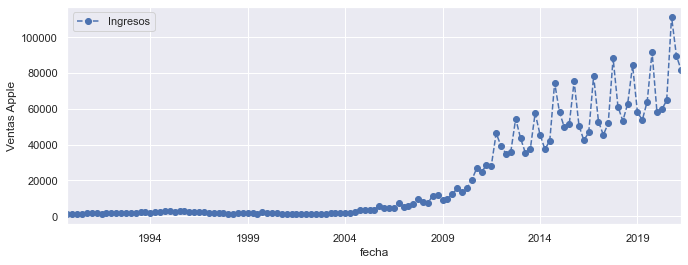

In [9]:
# Visualizamos la evolución de los ingresos
sns.set(rc={'figure.figsize':(11,4)})
ax = aapl_ts.plot(marker='o', linestyle='--')
ax.set_ylabel('Ventas Apple')

# Tendencia positiva con mayor volatilidad a partir de 2014

Text(0.5, 1.0, 'Comportamiento Estacional')

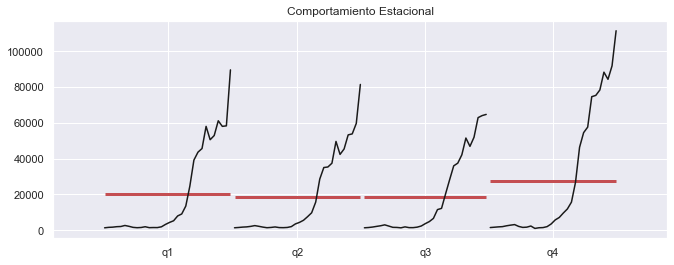

In [11]:
# Analizamos el comportamiento estacional
import statsmodels.api as sm
ax = plt.gca()
sm.graphics.tsa.quarter_plot(aapl_ts['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

# Observamos mayor valor medio en los últimos 3 meses del año (Q4)

In [12]:
# Modelos de suavizado exponencial
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS

119 8


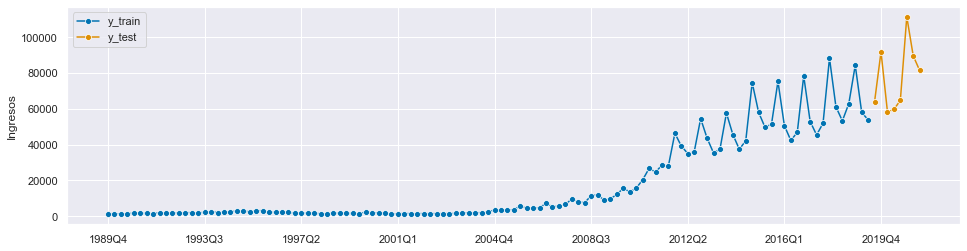

In [14]:
# Elegimos la distribución de los datos como set de entrenamiento y set de prueba

y_train, y_test = temporal_train_test_split(y = aapl_ts['Ingresos'].astype('float64').to_period('Q'), test_size=8)
# we will try to forecast y_test from y_train
# plotting for illustration
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [16]:
# determinar el horizonte de predicción (8 trimestres = 2 años)
fh = np.arange(1, 9)

# Determinar el algoritmo para la predicción
aapl_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)


In [18]:
# Ejecutrar el modelo Y visualización de los resultados
aapl_auto_model.fit(y_train)

print(aapl_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.026
Date:                Tue, 02 Nov 2021   AIC                           1956.052
Time:                        11:37:43   BIC                           1983.844
Sample:                    12-31-1989   HQIC                          1967.338
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

In [20]:
# predicciones para el set de prueba
aapl_pred = aapl_auto_model.predict(fh)
print(aapl_pred)

2019Q3    58581.390980
2019Q4    85963.098614
2020Q1    59751.889789
2020Q2    53079.672020
2020Q3    58323.668897
2020Q4    85584.497459
2021Q1    59488.438720
2021Q2    52845.381064
Freq: Q-DEC, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

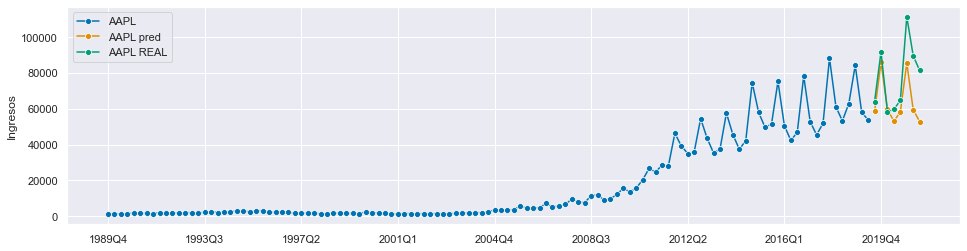

In [21]:
# Comparación de predicción con modelo ETS y datos reales
plot_series(y_train, aapl_pred,y_test, labels=["AAPL", 
                                               "AAPL pred", 
                                               "AAPL REAL"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

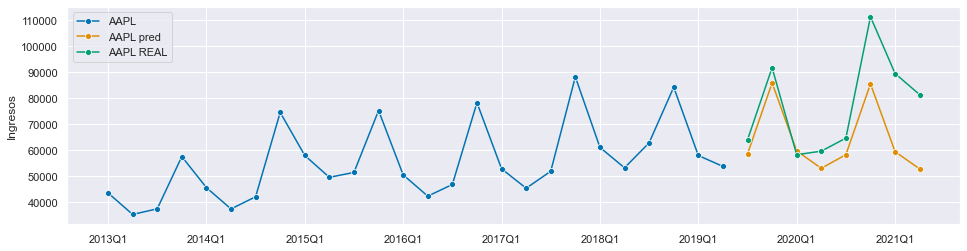

In [23]:
# VIsualización mas clara de las diferencias en las estimaciones
plot_series(y_train["2013":], aapl_pred,y_test, labels=["AAPL", 
                                                      "AAPL pred", 
                                                      "AAPL REAL"])

In [24]:
# Obtener el error medio corcentual para determinar la precisión del modelo
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, aapl_pred)

0.18651194416611905

In [25]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, aapl_pred)

317741011.8888919

In [26]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, aapl_pred)

17825.29135495103

In [27]:
# step 2: specifying forecasting horizon
fh = np.arange(1, 7)

# step 3: specifying the forecasting algorithm
aapl_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)

y = aapl_ts['Ingresos'].astype('float64').to_period('Q')

aapl_auto_model.fit(y)

print(aapl_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1052.312
Date:                Tue, 02 Nov 2021   AIC                           2124.623
Time:                        11:39:35   BIC                           2153.065
Sample:                    12-31-1989   HQIC                          2136.179
                         - 06-30-2021   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4303      0.055      7.816      0.000       0.322       0.538
smoothing_trend        0.1718      0.035      4.969      0.000       0.104       0.240
smoothing_seasonal  

In [28]:

aapl_pred_2 = aapl_auto_model.predict(fh)
print(aapl_pred_2)

2021Q3     94928.091075
2021Q4    153907.548732
2022Q1    112068.159032
2022Q2    104445.728063
2022Q3    120404.070052
2022Q4    192614.935467
Freq: Q-DEC, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

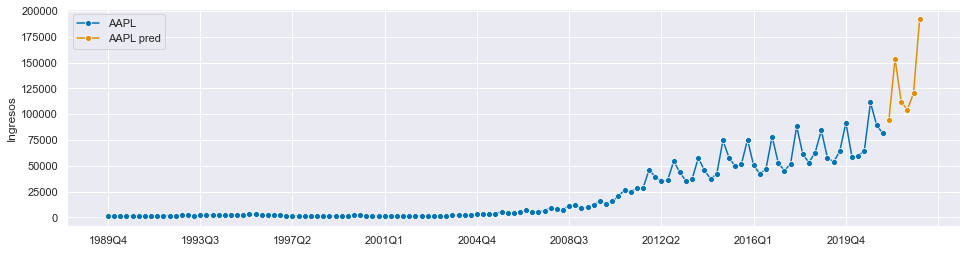

In [29]:
plot_series(y, aapl_pred_2, labels=["AAPL", "AAPL pred"])

In [30]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=4)
forecaster.fit(y)

/Users/hpp/Desktop/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing(seasonal='multiplicative', sp=4, trend='additive')

In [31]:
y_pred = forecaster.predict(fh)

In [32]:
print(forecaster._fitted_forecaster.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 Ingresos   No. Observations:                  127
Model:             ExponentialSmoothing   SSE                     1632170686.601
Optimized:                         True   AIC                           2094.862
Trend:                         Additive   BIC                           2117.615
Seasonal:                Multiplicative   AICC                          2096.758
Seasonal Periods:                     4   Date:                 Tue, 02 Nov 2021
Box-Cox:                          False   Time:                         11:40:02
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7121429                alpha                 True
smoothing_trend          

In [33]:
forecaster.get_fitted_params()

{'initial_level': 1371.1499999999992,
 'initial_slope': None,
 'initial_seasons': array([1.10433704, 0.98871863, 0.95210163, 0.9548427 ]),
 'aic': 2094.861677795224,
 'bic': 2117.6151744868926,
 'aicc': 2096.758229519362}

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

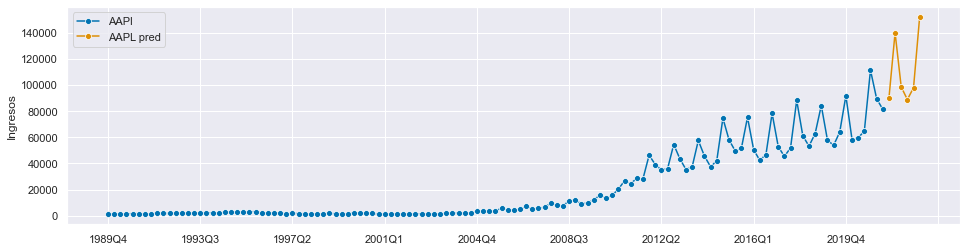

In [34]:
plot_series(y, y_pred, labels=["AAPl", "AAPL pred"])

In [35]:
forecaster = ExponentialSmoothing(trend='additive',seasonal=None, sp=4)
forecaster.fit(y)

/Users/hpp/Desktop/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


ExponentialSmoothing(sp=4, trend='additive')

In [36]:
y_pred = forecaster.predict(fh)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

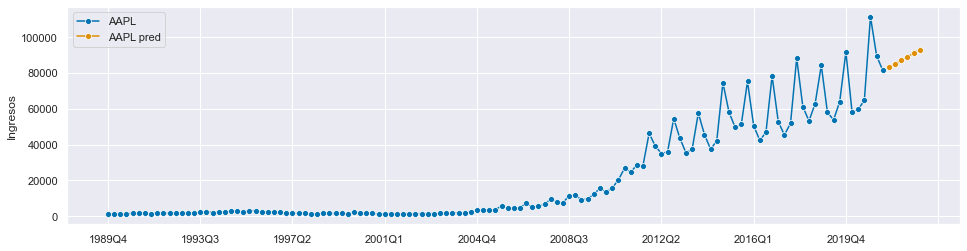

In [37]:
# Modelo sin componente estacional
plot_series(y, y_pred, labels=["AAPL", "AAPL pred"])

/Users/hpp/Desktop/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2021Q3     86660.531546
2021Q4    121476.774334
2022Q1     89868.614586
2022Q2     81219.915687
2022Q3     86660.531546
2022Q4    121476.774334
Freq: Q-DEC, dtype: float64

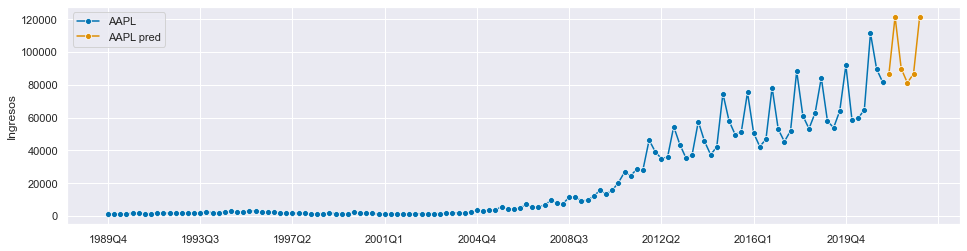

In [38]:
# Componente estacional aditivo
forecaster = ExponentialSmoothing(trend=None,seasonal="add", sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)
plot_series(y, y_pred, labels=["AAPL", "AAPL pred"])
y_pred

/Users/hpp/Desktop/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/hpp/Desktop/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

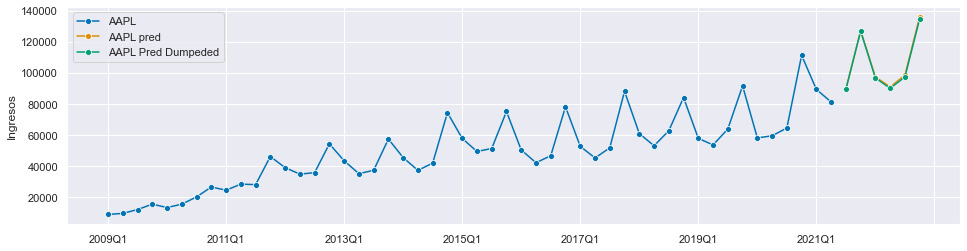

In [39]:
forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=False, sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh)

forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=True, sp=4)
forecaster.fit(y)
y_pred_dump = forecaster.predict(fh)
plot_series(y["2009":], y_pred, y_pred_dump,labels=["AAPL", 
                                                    "AAPL pred",
                                                    "AAPL Pred Dumpeded"])